# Calculate uncertainties in geodetic mass balance

## A brief introduction

The method is based on Hugonnet et al. (2022) and assess the uncertainty at 1-sigma level from the spatial correlation and the heteroscedacity of elevation change.

Hereafter, we follow two tutorials:
    - assessing the spatial correlation: https://xdem.readthedocs.io/en/latest/basic_examples/plot_infer_spatial_correlation.html
    - propagating the uncertainty: https://xdem.readthedocs.io/en/latest/basic_examples/plot_spatial_error_propagation.html
    
## Load the relevant packages

In [1]:
import geoutils as gu
import xdem
import numpy as np
import matplotlib.pyplot as plt

## Load the relevant data

In [2]:
path = 'C:/Users/brunbarf/Data/05_recherche/COSIPY/papier_Potocki/'

dh_map = path + 'DEM_diff_Pleiades/first_results_1984-2017/Data/Data/1984_2017_dh_WesternCwm_2m.tif'
shp_gla = path + 'DEM_diff_Pleiades/first_results_1984-2017/Data/Data/GAMDAM_Everest_sub_UTM45.shp'
ref_DEM_file =  path + 'DEM_diff_Pleiades/2017-03-23/Khumbu_2017-03-23_DEM_4m.tif'

dh = xdem.DEM(dh_map)
ref_dem = xdem.DEM(ref_DEM_file)
glacier_outlines = gu.Vector(shp_gla)


## Make sure the dh map and reference DEM are in the same proj and grid

In [3]:
# ref_dem = xdem.DEM(ref_dem).reproject(dh, silent=True)
dh = xdem.DEM(dh).reproject(ref_dem, silent=True)

## Optional: plot the dh map and DEM

(3083354.0, 3101266.0)

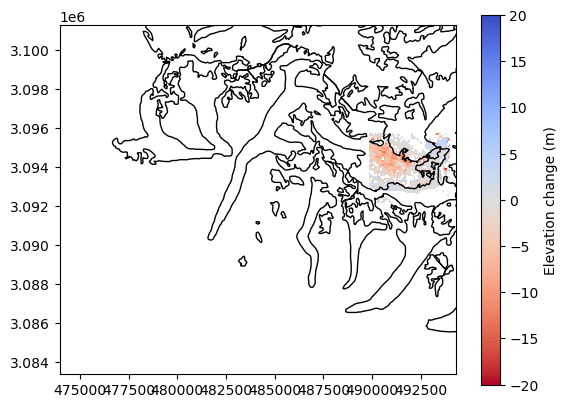

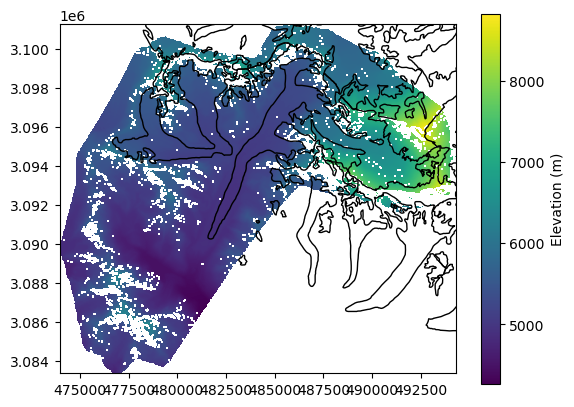

In [4]:
plt.figure()
ax = plt.subplot(111)
dh.show(ax=ax,cmap='coolwarm_r', vmin=-20, vmax=20, cb_title="Elevation change (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

plt.figure()
ax = plt.subplot(111)
ref_dem.show(ax=ax,cmap='viridis', cb_title="Elevation (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

## Empirical variogram and plot

C:\Users\brunbarf\Anaconda3\envs\xdem\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<Figure size 640x480 with 0 Axes>

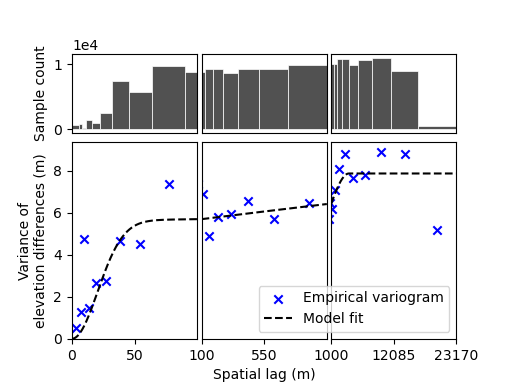

In [6]:
(
    df_empirical_variogram,
    df_model_params,
    spatial_corr_function,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=dh, list_models=["Gaussian", "Spherical"], unstable_mask=glacier_outlines
)

plt.figure()
xdem.spatialstats.plot_variogram(
    df=df_empirical_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(df_model_params)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m)",
    xscale_range_split=[100, 1000],
)

## Estimate heteroscedasticity

In [7]:
slope, maximum_curvature = xdem.terrain.get_terrain_attribute(ref_dem, attribute=["slope", "maximum_curvature"])
errors, df_binning, error_function = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dvalues=dh, list_var=[slope, maximum_curvature], list_var_names=["slope", "maxc"], unstable_mask=glacier_outlines
)

zscores = dh / errors
emp_variogram, params_variogram_model, spatial_corr_function = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=zscores, list_models=["Gaussian", "Spherical"], unstable_mask=glacier_outlines, random_state=42
)

C:\Users\brunbarf\Anaconda3\envs\xdem\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Spatial integration of variance on the target area

In [8]:
areas = [
    glacier_outlines.ds[glacier_outlines.ds["NAME"] == "SCG"]
]
stderr_glaciers = xdem.spatialstats.spatial_error_propagation(
    areas=areas, errors=errors, params_variogram_model=params_variogram_model
)

for glacier_name, stderr_gla in [("SCG", stderr_glaciers[0])]:
    print(f"The error (1-sigma) in mean elevation change for {glacier_name} is {stderr_gla:.2f} meters.")

The error (1-sigma) in mean elevation change for SCG is 0.58 meters.
